In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, pipeline
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate


# BERT 3-Class Sentiment Classification (Negative / Neutral / Positive)

This notebook fine-tunes a BERT model for 3-class sentiment classification using review text.
It includes preprocessing, training, evaluation, and error analysis.


In [3]:
## 1) Data loading & label mapping

In [4]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
print(dataset["full"][1])

{'rating': 4.0, 'title': 'Works great but smells a little weird.', 'text': 'This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (granted, I did know the smell was described but I was hoping it would be light)', 'images': [], 'asin': 'B081TJ8YS3', 'parent_asin': 'B081TJ8YS3', 'user_id': 'AGKHLEW2SOWHNMFQIJGBECAF7INQ', 'timestamp': 1588615855070, 'helpful_vote': 1, 'verified_purchase': True}


In [5]:
df=dataset["full"].to_pandas()

In [6]:
df1=df.copy()

In [7]:
# Map Rating to Sentiment Category
df1['sentiment_category'] = df1['rating'].apply(
    lambda x: 'positive' if x >= 4 
    else ('negative' if x <= 2 
    else 'neutral')
)


In [8]:
df1.head(1)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,sentiment_category
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True,positive


In [9]:
df1.drop(['images','asin','parent_asin','user_id','timestamp','helpful_vote','verified_purchase'], axis=1, inplace= True)

In [10]:
df1

,rating,title,text,sentiment_category
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,positive
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",positive
2,5.0,Yes!,"Smells good, feels great!",positive
3,1.0,Synthetic feeling,Felt synthetic,negative
4,5.0,A+,Love it,positive
...,...,...,...,...
701523,4.0,Four Stars,Conditioner is great shampoo not as I expected,positive
701524,1.0,Pretty,Did not work! Used the whole bottle and my hai...,negative
701525,5.0,Great sunless tanner,Product as expected. Shipping was on time.,positive
701526,5.0,The Crown on top is a Ring!!!,"Not only is it a delicious fragrance, but also...",positive


In [11]:
# Map sentiment_category to numerical labels
label_mapping = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}

df1['label'] = df1['sentiment_category'].map(label_mapping)


In [12]:
df1

,rating,title,text,sentiment_category,label
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,positive,0
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",positive,0
2,5.0,Yes!,"Smells good, feels great!",positive,0
3,1.0,Synthetic feeling,Felt synthetic,negative,2
4,5.0,A+,Love it,positive,0
...,...,...,...,...,...
701523,4.0,Four Stars,Conditioner is great shampoo not as I expected,positive,0
701524,1.0,Pretty,Did not work! Used the whole bottle and my hai...,negative,2
701525,5.0,Great sunless tanner,Product as expected. Shipping was on time.,positive,0
701526,5.0,The Crown on top is a Ring!!!,"Not only is it a delicious fragrance, but also...",positive,0


['positive' 'negative' 'neutral']


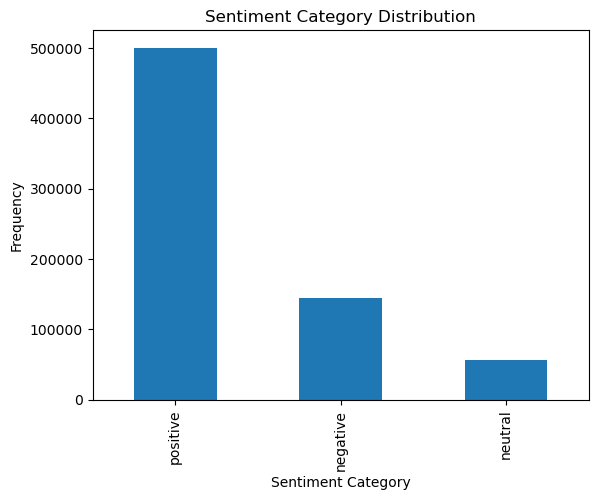

In [13]:
# Check the unique sentiment categories
print(df1['sentiment_category'].unique())

# Check the distribution of sentiment categories
df1['sentiment_category'].value_counts().plot(kind='bar')
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.show()


In [14]:
# Verify no missing values in 'text' and 'label'
print(df1[['text', 'label']].isnull().sum())


text     0
label    0
dtype: int64


In [15]:
# Ensure text has no NaN values
df1['text'] = df1['text'].fillna('')

# Replace empty or whitespace-only text with title
df1['text'] = df1.apply(
    lambda row: row['title'] if row['text'].strip() == '' else row['text'],
    axis=1
)


In [16]:
# Verify no text rows are empty
print(df1['text'].apply(lambda x: x.strip() == '').sum())  # Should print 0

# Check a few rows to verify replacement
print(df1[['text', 'title']].head())


0
                                                text  \
0  This spray is really nice. It smells really go...   
1  This product does what I need it to do, I just...   
2                          Smells good, feels great!   
3                                     Felt synthetic   
4                                            Love it   

                                       title  
0  Such a lovely scent but not overpowering.  
1     Works great but smells a little weird.  
2                                       Yes!  
3                          Synthetic feeling  
4                                         A+  


In [17]:
from transformers import BertTokenizer
from tqdm import tqdm
from datasets import Dataset

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Convert DataFrame to HuggingFace Dataset
dataset = Dataset.from_pandas(df1[['text', 'label']])

# Tokenize with TQDM progress bar
def manual_tokenize(dataset_subset, desc="Tokenizing Dataset"):
    tokenized_data = []
    for i in tqdm(range(0, len(dataset_subset), 100), desc=desc):
        batch = dataset_subset[i:i+100]
        tokenized_batch = tokenizer(
            batch['text'],  # Remove .tolist(), batch['text'] is already a list
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        tokenized_data.extend([
            {
                'input_ids': input_id,
                'attention_mask': attention_mask,
                'label': label
            }
            for input_id, attention_mask, label in zip(
                tokenized_batch['input_ids'],
                tokenized_batch['attention_mask'],
                batch['label']
            )
        ])
    return Dataset.from_list(tokenized_data)



In [18]:
# Apply tokenization
tokenized_dataset = manual_tokenize(dataset, desc="Tokenizing Dataset with TQDM")

# Verify tokenized dataset
print(tokenized_dataset[0])


Tokenizing Dataset with TQDM: 100%|████████████████████████████████████████████████| 7016/7016 [19:24<00:00,  6.03it/s]


{'input_ids': [101, 2023, 12509, 2003, 2428, 3835, 1012, 2009, 14747, 2428, 2204, 1010, 3632, 2006, 2428, 2986, 1010, 1998, 2515, 1996, 7577, 1012, 1045, 2097, 2360, 2009, 5683, 2066, 2017, 2342, 1037, 2843, 1997, 2009, 2295, 2000, 2131, 1996, 14902, 1045, 2215, 1012, 1045, 2031, 1037, 2843, 1997, 2606, 1010, 5396, 14983, 1012, 1045, 2572, 13599, 2000, 2060, 9639, 2007, 9805, 17413, 12141, 2061, 1045, 1005, 1049, 6069, 6293, 2007, 2023, 1012, 3046, 2009, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [17]:
tokenized_dataset.shape

(701528, 3)

In [18]:
print("Tokenized Dataset Length:", len(tokenized_dataset))
print(tokenized_dataset[0])


Tokenized Dataset Length: 701528
{'input_ids': [101, 2023, 12509, 2003, 2428, 3835, 1012, 2009, 14747, 2428, 2204, 1010, 3632, 2006, 2428, 2986, 1010, 1998, 2515, 1996, 7577, 1012, 1045, 2097, 2360, 2009, 5683, 2066, 2017, 2342, 1037, 2843, 1997, 2009, 2295, 2000, 2131, 1996, 14902, 1045, 2215, 1012, 1045, 2031, 1037, 2843, 1997, 2606, 1010, 5396, 14983, 1012, 1045, 2572, 13599, 2000, 2060, 9639, 2007, 9805, 17413, 12141, 2061, 1045, 1005, 1049, 6069, 6293, 2007, 2023, 1012, 3046, 2009, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [19]:


# Load Evaluation Metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Define Compute Metrics Function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get predicted class indices
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }


In [20]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",  # Directory to save checkpoints and logs
    per_device_train_batch_size=256,  # Adjust for your GPU memory
    per_device_eval_batch_size=256,  # Batch size during evaluation
    evaluation_strategy="steps",  # Evaluate at regular intervals
    eval_steps=500,  # Evaluation every 500 steps
    save_steps=500,  # Save every 500 steps
    logging_steps=100,  # Log every 100 steps
    learning_rate=2e-5,  # Default learning rate for fine-tuning BERT
    weight_decay=0.01,  # Regularization to prevent overfitting
    fp16=True if torch.cuda.is_available() else False,  # Enable mixed precision if CUDA is available
    save_total_limit=2,  # Keep only the last 2 checkpoints
    load_best_model_at_end=True,  # Load the best model at the end of training
    report_to="none",  # Disable reporting to external platforms like wandb
    logging_dir="./logs",  # Directory for logs
    seed=42  # Ensure reproducibility
)


C:\Users\yadav\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:


# Define the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',  # Pre-trained BERT model
    num_labels=3          # Number of sentiment classes (positive, neutral, negative)
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
print(model.config.num_labels)


3


In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model,                   # Pre-trained BERT model
    args=training_args,            # Training arguments
    train_dataset=tokenized_dataset,  # Training dataset (optional if only evaluating)
    eval_dataset=tokenized_dataset,   # Evaluation dataset
    tokenizer=tokenizer,           # Tokenizer used for preprocessing
    #compute_metrics=compute_metrics # Metric calculation function
)


C:\Users\yadav\AppData\Local\Temp\ipykernel_24348\4185280363.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\yadav\anaconda3\Lib\site-packages\accelerate\accelerator.py:449: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [23]:
# Evaluate the model on the tokenized dataset
results = trainer.evaluate()
print("Evaluation Metrics:", results)


Evaluation Metrics: {'eval_loss': 0.938940703868866, 'eval_model_preparation_time': 0.0044, 'eval_runtime': 1047.9169, 'eval_samples_per_second': 669.45, 'eval_steps_per_second': 2.616}


In [57]:
# Evaluate the model on the tokenized dataset
results = trainer.evaluate()
print("Evaluation Metrics:", results)


Evaluation Metrics: {'eval_loss': 1.0809935331344604, 'eval_model_preparation_time': 0.003, 'eval_accuracy': 0.35774338301536074, 'eval_precision': 0.5770035672456504, 'eval_recall': 0.35774338301536074, 'eval_f1': 0.4225859934346382, 'eval_runtime': 968.3506, 'eval_samples_per_second': 724.457, 'eval_steps_per_second': 2.831}


In [58]:
# Evaluate on the test dataset and get predictions
eval_dataset = tokenized_dataset

# Make predictions using the Trainer
predictions_output = trainer.predict(eval_dataset)

# Extract logits and labels
logits_normal = predictions_output.predictions  # Raw output from the model
labels_normal = predictions_output.label_ids    # True labels


In [59]:
# Extract logits and labels
logits_normal = predictions_output.predictions  # Raw output from the model
labels_normal = predictions_output.label_ids    # True labels

In [60]:
logits_normal

array([[0.5361328 , 0.5649414 , 0.26342773],
       [0.5102539 , 0.49951172, 0.41601562],
       [0.47583008, 0.5395508 , 0.22387695],
       ...,
       [0.50878906, 0.48046875, 0.13439941],
       [0.47827148, 0.6152344 , 0.22912598],
       [0.50390625, 0.5371094 , 0.32666016]], dtype=float32)

In [61]:

# Convert logits to predicted labels using argmax
predicted_labels_normal = np.argmax(logits_normal, axis=1)


In [62]:
predicted_labels_normal.shape

(701528,)

In [63]:
# Verify shapes
print("Logits Shape:", logits_normal.shape)
print("Predicted Labels Shape:", predicted_labels_normal.shape)
print("Sample Predictions:", predicted_labels_normal[:5])


Logits Shape: (701528, 3)
Predicted Labels Shape: (701528,)
Sample Predictions: [1 0 1 0 0]


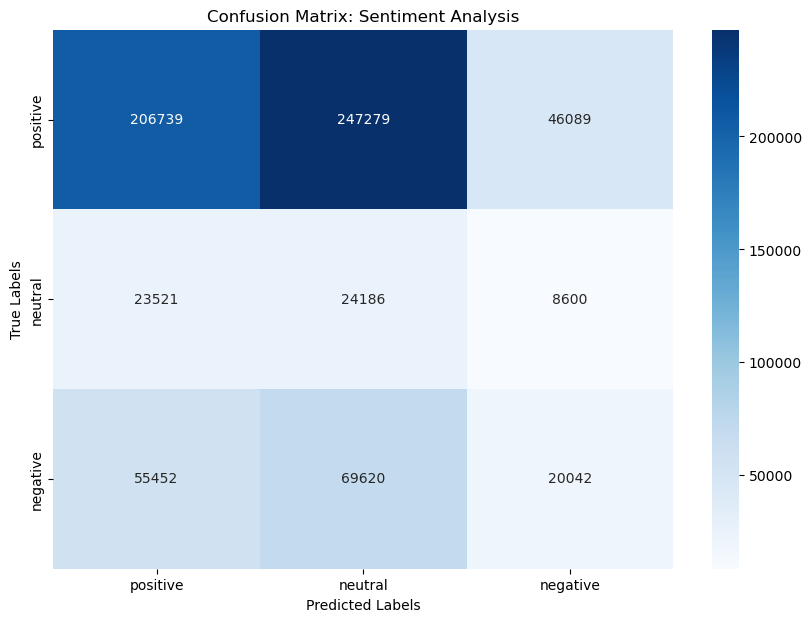

In [64]:
cm = confusion_matrix(labels_normal, predicted_labels_normal)
class_names = ['positive', 'neutral', 'negative']

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Sentiment Analysis')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [65]:

# Create a DataFrame for Graphs
# Calculate Probabilities from Logits using Softmax
probabilities_n = np.exp(logits_normal) / np.sum(np.exp(logits_normal), axis=1, keepdims=True)

# Create a DataFrame for Graphs
probability_df_normal = pd.DataFrame({
    'True Label': labels_normal,
    'Predicted Label': predicted_labels_normal,
    'Positive Probability': probabilities_n[:, 0],
    'Neutral Probability': probabilities_n[:, 1],
    'Negative Probability': probabilities_n[:, 2],
    'Max Probability': np.max(probabilities_n, axis=1)
})

# Map class labels
label_mapping = {0: 'Positive', 1: 'Neutral', 2: 'Negative'}
probability_df_normal['True Label'] = probability_df_normal['True Label'].map(label_mapping)
probability_df_normal['Predicted Label'] = probability_df_normal['Predicted Label'].map(label_mapping)

# ✅ Add a column to flag correct predictions
probability_df_normal['is_correct'] = (probability_df_normal['True Label'] == probability_df_normal['Predicted Label']).astype(int)

# Verify the updated DataFrame
print(probability_df_normal.head())



  True Label Predicted Label  Positive Probability  Neutral Probability  \
0   Positive         Neutral              0.358353             0.368827   
1   Positive        Positive              0.344901             0.341216   
2   Positive         Neutral              0.351732             0.374874   
3   Negative        Positive              0.367650             0.291582   
4   Positive        Positive              0.394251             0.303318   

   Negative Probability  Max Probability  is_correct  
0              0.272820         0.368827           0  
1              0.313883         0.344901           1  
2              0.273394         0.374874           0  
3              0.340769         0.367650           0  
4              0.302431         0.394251           1  


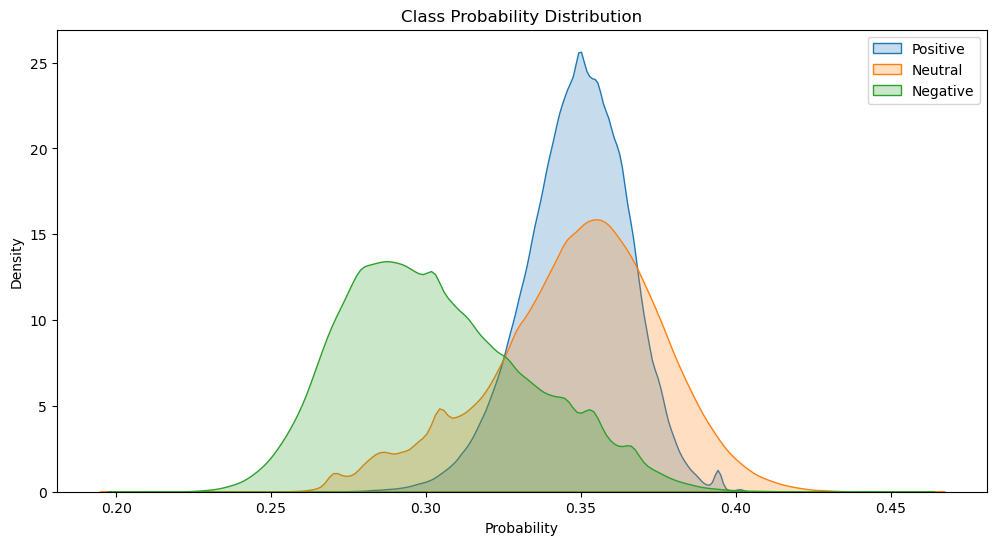

In [66]:
# Class Probability Distribution Plot

plt.figure(figsize=(12, 6))
sns.kdeplot(probability_df_normal['Positive Probability'], label='Positive', fill=True)
sns.kdeplot(probability_df_normal['Neutral Probability'], label='Neutral', fill=True)
sns.kdeplot(probability_df_normal['Negative Probability'], label='Negative', fill=True)

plt.title('Class Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()


C:\Users\yadav\AppData\Local\Temp\ipykernel_23260\757633241.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_metrics = probability_df_normal.groupby('True Label').apply(


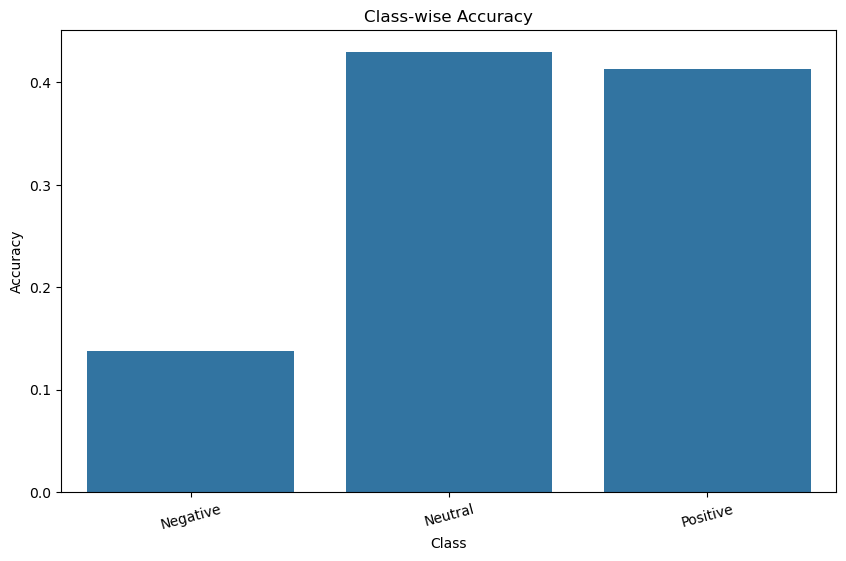

In [282]:
# Class-Wise Accuracy Plot
class_metrics = probability_df_normal.groupby('True Label').apply(
    lambda x: (x['True Label'] == x['Predicted Label']).mean()
).reset_index(name='Accuracy')

plt.figure(figsize=(10, 6))
sns.barplot(data=class_metrics, x='True Label', y='Accuracy')
plt.title('Class-wise Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.show()


In [285]:
from rich.console import Console
from rich.table import Table
import pandas as pd
import numpy as np

# Overall Metrics Table
console = Console()
table = Table(title="Class-wise Accuracy and Misclassification")

# Add Columns
table.add_column("True Label")
table.add_column("Total Samples")
table.add_column("Correct Predictions")
table.add_column("Accuracy (%)")
table.add_column("Misclassification (%)")
table.add_column("Avg Max Probability")

# ✅ Calculate Class-Level Metrics
class_metrics = probability_df_normal.groupby('True Label').apply(
    lambda group: pd.Series({
        'total_samples': group['True Label'].count(),
        'correct_predictions': (group['True Label'] == group['Predicted Label']).sum(),
        'accuracy': (group['True Label'] == group['Predicted Label']).mean() * 100,
        'misclassification': (1 - (group['True Label'] == group['Predicted Label']).mean()) * 100,
        'avg_max_probability': group['Max Probability'].mean()
    })
).reset_index()

# ✅ Fill Table
for _, row in class_metrics.iterrows():
    table.add_row(
        row['True Label'],
        str(row['total_samples']),
        str(row['correct_predictions']),
        f"{row['accuracy']:.2f}",
        f"{row['misclassification']:.2f}",
        f"{row['avg_max_probability']:.2f}"
    )

# ✅ Add Overall Row
table.add_row(
    "Overall",
    str(probability_df_normal.shape[0]),
    str((probability_df_normal['True Label'] == probability_df_normal['Predicted Label']).sum()),
    f"{(probability_df_normal['True Label'] == probability_df_normal['Predicted Label']).mean() * 100:.2f}",
    "-",
    f"{probability_df_normal['Max Probability'].mean():.2f}"
)

# ✅ Display Table
console.print(table)


C:\Users\yadav\AppData\Local\Temp\ipykernel_23260\1466312219.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_metrics = probability_df_normal.groupby('True Label').apply(


                                    Class-wise Accuracy and Misclassification                                    
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ True Label ┃ Total Samples ┃ Correct Predictions ┃ Accuracy (%) ┃ Misclassification (%) ┃ Avg Max Probability ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ Negative   │ 145114.0      │ 20042.0             │ 13.81        │ 86.19                 │ 0.36                │
│ Neutral    │ 56307.0       │ 24186.0             │ 42.95        │ 57.05                 │ 0.36                │
│ Positive   │ 500107.0      │ 206739.0            │ 41.34        │ 58.66                 │ 0.37                │
│ Overall    │ 701528        │ 250967              │ 35.77        │ -                     │ 0.36                │
└────────────┴───────────────┴─────────────────────┴──────────────┴───────────────────────┴─────────────────────┘

Training of BERT

In [35]:

# First Split: 50% Train+Validation, 50% Test
train_val_test_split = tokenized_dataset.train_test_split(
    test_size=0.5,
    shuffle=True,
    seed=42
)

# Second Split: Train (80%) and Validation (20%) from Train+Validation
train_val_split = train_val_test_split['train'].train_test_split(
    test_size=0.2,
    shuffle=True,
    seed=42
)

# Final Dataset Dictionary
dataset_splits = DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': train_val_test_split['test']
})



In [36]:
# Print dataset sizes to verify
print("Training Dataset Size:", len(dataset_splits['train']))
print("Validation Dataset Size:", len(dataset_splits['validation']))
print("Test Dataset Size:", len(dataset_splits['test']))


Training Dataset Size: 280611
Validation Dataset Size: 70153
Test Dataset Size: 350764


In [42]:

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',  # Evaluate after each epoch
    save_strategy='epoch',        # Save the model after each epoch
    load_best_model_at_end=True,  # Load the best model at the end
    save_total_limit=2,           # Keep only the last 2 checkpoints
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
    logging_steps=10,
    fp16=True if torch.cuda.is_available() else False,
    save_steps=500,
    eval_steps=500
)


In [43]:
# Verify Arguments
print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=500,
eval_strategy=IntervalStrategy.EPOCH,
eval_u

In [48]:

# Initialize the Trainer
trainer = Trainer(
    model=model,                      # Pre-trained BERT model
    args=training_args,               # Training arguments
    train_dataset=dataset_splits['train'],      # Training dataset
    eval_dataset=dataset_splits['validation'],  # Validation dataset
    tokenizer=tokenizer,              # Tokenizer for preprocessing
    compute_metrics=compute_metrics   # Metrics calculation function
)

C:\Users\yadav\AppData\Local\Temp\ipykernel_23260\2249971731.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [49]:

# Verify Trainer Setup
print(trainer)


In [50]:
# Start training the model

DO_TRAIN = False  # set True only if you want to train
if DO_TRAIN:
    trainer.train()
    trainer.save_model("./BERT_3_classification")
else:
    print("Skipping training (DO_TRAIN=False). Using saved model.")


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.225500,0.288209,0.893547,0.872989,0.893547,0.874503
2,0.276800,0.270719,0.898550,0.892819,0.898550,0.895201
3,0.176800,0.306587,0.896498,0.893295,0.896498,0.894732


TrainOutput(global_step=13155, training_loss=0.23375601400127433, metrics={'train_runtime': 4823.9165, 'train_samples_per_second': 174.512, 'train_steps_per_second': 2.727, 'total_flos': 5.537438944655386e+16, 'train_loss': 0.23375601400127433, 'epoch': 3.0})

In [51]:
# Save the trained model
trainer.save_model("./BERT_3_classification")

In [52]:
loaded_model = BertForSequenceClassification.from_pretrained("./BERT_3_classification")
loaded_tokenizer = BertTokenizer.from_pretrained("./BERT_3_classification")

# Verify model configuration
print("✅ Model and tokenizer reloaded successfully.")
print("Number of labels:", loaded_model.config.num_labels)

✅ Model and tokenizer reloaded successfully.
Number of labels: 3


Testing

In [54]:
# Initialize the Trainer with the loaded model
loaded_trainer = Trainer(
    model=loaded_model,
    args=training_args,
    eval_dataset=dataset_splits['test'],
    tokenizer=loaded_tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\yadav\AppData\Local\Temp\ipykernel_23260\2395382595.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  loaded_trainer = Trainer(
C:\Users\yadav\anaconda3\Lib\site-packages\accelerate\accelerator.py:449: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [55]:
# Evaluate the fine-tuned model on the test dataset
test_results = loaded_trainer.evaluate()

Evaluation

In [56]:
# Print evaluation metrics
print("📊 Test Dataset Evaluation Metrics:")
print(test_results)

📊 Test Dataset Evaluation Metrics:
{'eval_loss': 0.2692427933216095, 'eval_model_preparation_time': 0.0076, 'eval_accuracy': 0.8980083474929013, 'eval_precision': 0.8922478725814834, 'eval_recall': 0.8980083474929013, 'eval_f1': 0.8946585464600816, 'eval_runtime': 577.2777, 'eval_samples_per_second': 607.617, 'eval_steps_per_second': 9.495}


In [57]:
# Evaluate on the test dataset and get predictions
eval_dataset = dataset_splits['test']

# Make predictions using the Trainer
predictions_output_trained = trainer.predict(eval_dataset)

# Extract logits and labels
logits_trained = predictions_output_trained.predictions  # Raw output from the model
labels_trained = predictions_output_trained.label_ids    # True labels


In [61]:
# Convert logits to predicted labels using argmax
predicted_labels_trained = np.argmax(logits_trained, axis=1)


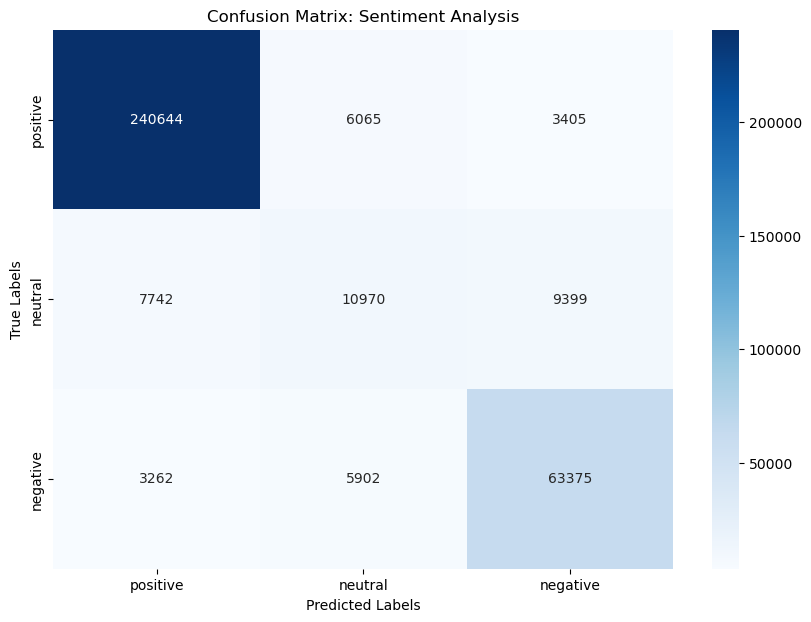

In [62]:
cm = confusion_matrix(labels_trained, predicted_labels_trained)
class_names = ['positive', 'neutral', 'negative']

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Sentiment Analysis')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

Testing on trained BERT model random sentences 

In [75]:
# Load Fine-Tuned Model
sentiment_pipeline = pipeline(
    "text-classification",
    model="./BERT_3_classification",  # Path to your fine-tuned BERT model
    tokenizer="./BERT_3_classification",
    device=0 if torch.cuda.is_available() else -1
)

# Example Text Input
text = "this was soo ugh that it was not possible to use"

# Get Prediction
result = sentiment_pipeline(text)




Device set to use cuda:0


In [94]:
label_map = {
    'LABEL_0': 'positive',
    'LABEL_1': 'neutral',
    'LABEL_2': 'negative'
}

# Get Prediction
text = "this was soo ugh that it was not possible to use"
result = sentiment_pipeline(text)

In [95]:
# Display Output with Mapping
print("Input Text:", text)
print("Predicted Sentiment:", label_map.get(result[0]['label'], "Unknown Label"))
print("Confidence Score:", result[0]['score'])

Input Text: this was soo ugh that it was not possible to use
Predicted Sentiment: negative
Confidence Score: 0.9925515651702881


In [96]:
# using misspelling but the intention is negative 
text = " this product was so tought to handle that it is possibel to handle"
result = sentiment_pipeline(text)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [97]:
# Display Output with Mapping
print("Input Text:", text)
print("Predicted Sentiment:", label_map.get(result[0]['label'], "Unknown Label"))
print("Confidence Score:", result[0]['score'])

Input Text:  this product was so tought to handle that it is possibel to handle
Predicted Sentiment: negative
Confidence Score: 0.8519490957260132


In [98]:
# using misspelling but the intention is negative 
text = " it was not that great but we can still use it "
result = sentiment_pipeline(text)

In [99]:
# Display Output with Mapping
print("Input Text:", text)
print("Predicted Sentiment:", label_map.get(result[0]['label'], "Unknown Label"))
print("Confidence Score:", result[0]['score'])

Input Text:  it was not that great but we can still use it 
Predicted Sentiment: neutral
Confidence Score: 0.6486542820930481


In [113]:

# Calculate Probabilities from Logits
probabilities = np.exp(logits_trained) / np.sum(np.exp(logits_trained), axis=1, keepdims=True)

# Get Predicted Labels
predicted_labels = np.argmax(probabilities, axis=1)

# Define Class Mapping
label_mapping = {
    0: 'positive',
    1: 'neutral',
    2: 'negative'
}

# Build a DataFrame for Sample-level Metrics
sample_metrics = pd.DataFrame({
    'true_label': labels_trained,
    'predicted_label': predicted_labels,
    'max_probability': np.max(probabilities, axis=1),
    'prob_positive': probabilities[:, 0],
    'prob_neutral': probabilities[:, 1],
    'prob_negative': probabilities[:, 2]
})

# Add Misclassification Flag
sample_metrics['is_correct'] = sample_metrics['true_label'] == sample_metrics['predicted_label']


In [153]:
data_probabilites=pd.DataFrame(probabilities)

In [158]:
probabilities

array([[0.992286  , 0.00620165, 0.00151238],
       [0.99153405, 0.00696062, 0.00150534],
       [0.00213356, 0.00328521, 0.9945812 ],
       ...,
       [0.03427123, 0.04215433, 0.92357445],
       [0.9837608 , 0.01410817, 0.00213105],
       [0.00187485, 0.00195525, 0.99616987]], dtype=float32)

In [160]:
data_probabilites=pd.DataFrame(probabilities)

In [162]:
data_probabilites['min']=data_probabilites.min(axis=1)

In [163]:
data_probabilites

,0,1,2,min
0,0.992286,0.006202,0.001512,0.001512
1,0.991534,0.006961,0.001505,0.001505
2,0.002134,0.003285,0.994581,0.002134
3,0.238145,0.454687,0.307168,0.238145
4,0.998258,0.001279,0.000463,0.000463
...,...,...,...,...
350759,0.955910,0.041147,0.002943,0.002943
350760,0.008609,0.076432,0.914959,0.008609
350761,0.034271,0.042154,0.923574,0.034271
350762,0.983761,0.014108,0.002131,0.002131


In [119]:

# ✅ Class Mapping for Sentiment Labels
label_mapping = {
    0: 'positive',
    1: 'neutral',
    2: 'negative'
}

# ✅ Class-Level Metrics Aggregation
class_metrics = (
    sample_metrics
    .groupby('true_label')
    .agg(
        total_samples=('true_label', 'count'),            # Total samples per class
        correct_predictions=('is_correct', 'sum'),        # Total correct predictions per class
        accuracy=('is_correct', 'mean'),                 # Accuracy per class
        misclassification=('is_correct', lambda x: 1 - x.mean()),  # Misclassification rate
        avg_max_probability=('max_probability', 'mean')   # Average confidence for predictions
    )
    .reset_index()
    .assign(
        class_name=lambda df: df['true_label'].map(label_mapping)  # Map to descriptive labels
    )
    .drop(columns=['true_label'])  # Remove numeric label column if not needed
)

# ✅ Overall Metrics Calculation
total_correct_predictions = sample_metrics['is_correct'].sum()
total_samples = sample_metrics.shape[0]
overall_accuracy = (total_correct_predictions / total_samples) * 100


In [121]:
from rich.console import Console
from rich.table import Table

console = Console()
table = Table(title="Class-wise Accuracy and Misclassification")

# Add Columns
table.add_column("Class Name")
table.add_column("Total Samples")
table.add_column("Correct Predictions")
table.add_column("Accuracy (%)")
table.add_column("Misclassification (%)")
table.add_column("Avg Max Probability")

# Add Rows for Class-Level Metrics
for _, row in class_metrics.iterrows():
    table.add_row(
        row['class_name'],  # Use 'class_name' instead of 'true_label'
        str(row['total_samples']),
        str(row['correct_predictions']),
        f"{row['accuracy'] * 100:.2f}",
        f"{row['misclassification'] * 100:.2f}",
        f"{row['avg_max_probability']:.2f}"
    )

# Add Overall Row
table.add_row(
    "Overall",
    str(total_samples),
    str(total_correct_predictions),
    f"{overall_accuracy:.2f}",
    "-",
    "-"
)

# Display Table
console.print(table)


                                    Class-wise Accuracy and Misclassification                                    
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Class Name ┃ Total Samples ┃ Correct Predictions ┃ Accuracy (%) ┃ Misclassification (%) ┃ Avg Max Probability ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ positive   │ 250114        │ 240644              │ 96.21        │ 3.79                  │ 0.96                │
│ neutral    │ 28111         │ 10970               │ 39.02        │ 60.98                 │ 0.70                │
│ negative   │ 72539         │ 63375               │ 87.37        │ 12.63                 │ 0.85                │
│ Overall    │ 350764        │ 314989              │ 89.80        │ -                     │ -                   │
└────────────┴───────────────┴─────────────────────┴──────────────┴───────────────────────┴─────────────────────┘

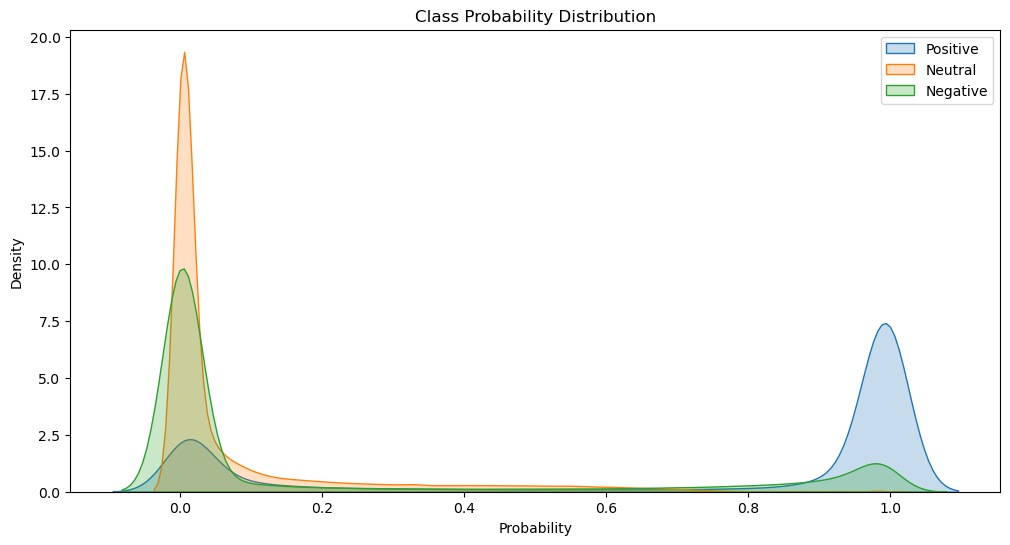

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.kdeplot(sample_metrics['prob_positive'], label='Positive', fill=True)
sns.kdeplot(sample_metrics['prob_neutral'], label='Neutral', fill=True)
sns.kdeplot(sample_metrics['prob_negative'], label='Negative', fill=True)

plt.title('Class Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()


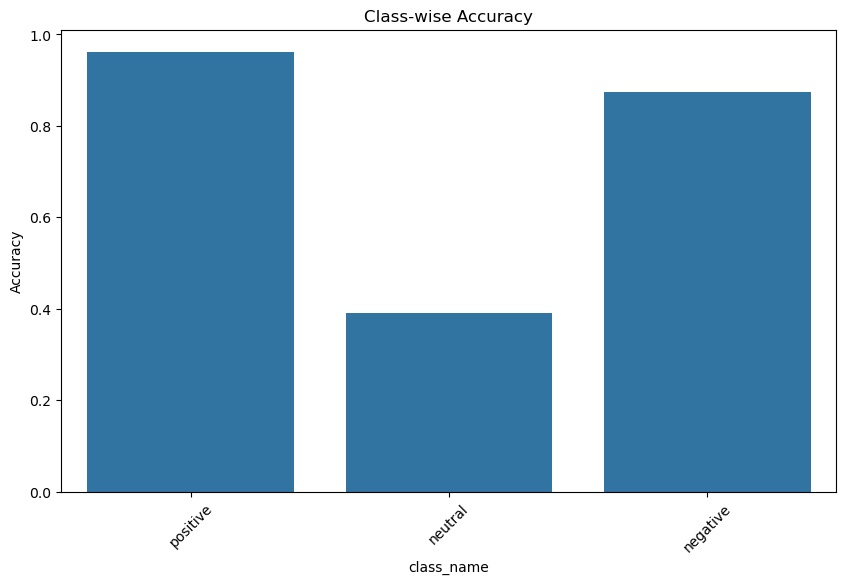

In [123]:
plt.figure(figsize=(10, 6))
sns.barplot(data=class_metrics, x='class_name', y='accuracy')
plt.title('Class-wise Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()


In [125]:
sample_metrics

,true_label,predicted_label,max_probability,prob_positive,prob_neutral,prob_negative,is_correct
0,1,0,0.992286,0.992286,0.006202,0.001512,False
1,0,0,0.991534,0.991534,0.006961,0.001505,True
2,2,2,0.994581,0.002134,0.003285,0.994581,True
3,2,1,0.454687,0.238145,0.454687,0.307168,False
4,0,0,0.998258,0.998258,0.001279,0.000463,True
...,...,...,...,...,...,...,...
350759,0,0,0.955910,0.955910,0.041147,0.002943,True
350760,2,2,0.914959,0.008609,0.076432,0.914959,True
350761,2,2,0.923574,0.034271,0.042154,0.923574,True
350762,0,0,0.983761,0.983761,0.014108,0.002131,True


In [142]:
sample_metrics

,true_label,predicted_label,max_probability,prob_positive,prob_neutral,prob_negative,is_correct,class_name
0,1,0,0.992286,0.992286,0.006202,0.001512,False,neutral
1,0,0,0.991534,0.991534,0.006961,0.001505,True,positive
2,2,2,0.994581,0.002134,0.003285,0.994581,True,negative
3,2,1,0.454687,0.238145,0.454687,0.307168,False,negative
4,0,0,0.998258,0.998258,0.001279,0.000463,True,positive
...,...,...,...,...,...,...,...,...
350759,0,0,0.955910,0.955910,0.041147,0.002943,True,positive
350760,2,2,0.914959,0.008609,0.076432,0.914959,True,negative
350761,2,2,0.923574,0.034271,0.042154,0.923574,True,negative
350762,0,0,0.983761,0.983761,0.014108,0.002131,True,positive


In [138]:
predicted_labels_trained

array([0, 0, 2, ..., 2, 0, 2], dtype=int64)

In [101]:
# Check Probability Range
print("Max Probability:", np.max(probabilities))
print("Min Probability:", np.min(probabilities))
print("Mean Probability:", np.mean(probabilities))


Max Probability: 0.9988988
Min Probability: 0.00028746788
Mean Probability: 0.33333337
